In [2]:
# imports

import os
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotly.subplots import make_subplots
from scipy.stats import skew
from IPython.core.display import HTML 
from stargazer.stargazer import Stargazer

### 1. CO2 Emissions and Climate Change Policies

*A Notebook by Dan Luca Fulger, Siméon Migeotte, and Per Christian Wessel*

Total historic emissions have been used to measure the climate responsibility of a country ([BASIC experts, 2011](http://gdrights.org/wp-content/uploads/2011/12/EASD-final.pdf)). The public discussion about blame has moved to the center stage much due to the 'Loss and Damage' protocol during COP27. We want to see if high emitting countries has taken measures not just by creating but by implementing climate change laws and policies. To do this we have gathered total historic emissions data from [Our World In data](https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions) and analyzing the effects of emissions on rate of which climate change policies have been adopted.

This notebook is used both to investigate a research question, but also as a working guide on python, pandas, data cleaning, data exploration, data visualization, statistical modeling, and regression analysis to gain insight and knowledge of how to address the concept of causality.



#### 1.1 Research Question

Our Research question breaks down to: 

<p style="text-align:center;"> 💭 Does CO2 emissions influence the number of implemented climate change laws and policies?💭</p>
<br>
We will then investigate if high polluting countries react different than low polluting countries to global agreements such as the Paris Agreement in 2015. And if so, can we determine the causality between such a treaty and change in climate behavior by measuring implemented climate change laws and policies.




#### 1.2 Literature Research

A vital question regarding climate laws is their effectiveness, does more climate change laws actually reduce emissions? 

We need to address if the quantity of emitted CO2 decrease as laws and policies are set in place. After conducting a literature search, we found an article that investigates the effect of such laws and policies, called "[Reduction in greenhouse gas emissions from national climate legislation](https://eprints.lse.ac.uk/105757/1/Eskander_Fankhauser_NCC_Author_Accepted_Manuscript.pdf)" and was written by Shaikh M. S. U. Eskander and Sam Fankhauser. They concluded with "Each new law reduces annual carbon dioxide (CO2) emissions per unit of gross domestic product by 0.78% nationally in the short term (during the first three years) and by 1.79% in the long term (beyond three years)". This study helped us understand why the reverse causality is one of the main issue of our study. With the cross-sectional analysis, we can diminish this bias, however there are a lot of omitted variables that could influence the number of policies and the yearly emissions as well, some of these will be discussed later.

In the article called “[How inequitable is the global distribution of responsibility, capability, and vulnerability to climate change: A comprehensive indicator-based assessment](https://www.sciencedirect.com/science/article/pii/S0959378010000683)”, Hans-Martin Füssel, the author, investigates the relation between responsibility and vulnerability. His article has brought a robust assessment of the implications of climate change on international inequity. He explored the different correlations between vulnerability, capabilities and responsibility. The analysis finds a double inequity between countries’ responsibility/capability and vulnerability for food security, human health, and coastal populations. This article suggests that countries more responsible and often more capable should support vulnerable countries through financial and technical aid. Our article relates to Füssel's article as we investigate if countries that have emitted a lot are implementing new climate laws and policies. 

### 2. Exploratory data analysis on aggregated data

We will begin by doing a cross-sectional data analysis of total historic emissions until 2010 versus total number of climate change laws passed after 2012. The reasoning behind the two year gap is that laws implemented after 2012 does not effect the emissions before 2010, thus removing the issue of reverse causality bias. In general, the visualization and analysis of the aggregated data will be a preliminary analysis to gain insight and help us develop a more robust statistical approach to our data.

#### 2.1 Extracting the CO2 emission and QOG data

Under is a table of the different variables we collect and calculate, we have renamed some of them to be more explicit. 

| Explanation | QOG variable name | Our variable name |
| --- | ----------- | ----------- |
| Cumulative Climate Change Laws implemented (1) |ccl_nlp | cc_laws_tot |
| Climate Change Laws implemented per year (2) |ccl_lpp | cc_laws_year |
| Country name |country | - |
| Year |year | - |
| Country Code (iso3) |iso_code | iso3 |
| CO2 emissions / year |co2 | - (tons) |
| Country population |population | - |
| Gross Domestic Product | gdp | - ($) |
| CO2 emissions / year / capita (Calculated by us) | - | co2_per_capita (tons) |
| Gross Domestic Product / capita (Calculated by us) | - | gdp_per_capita ($) |

(1) Number of climate change-related laws (legislative acts) and policies (executive provisions) adopted per year <br>
(2) Cumulative sum of climate change-related laws (legislative acts) and policies (executive provisions) adopted per year <br>

Remark, to simplify when we talk about laws we mean laws and policies.

In [3]:
# Fetching emission data from Our World In Data
# https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions
# https://github.com/owid/co2-data
# Fetching QOG data from Eduardo

url_co2 = 'https://nyc3.digitaloceanspaces.com/owid-public/data/co2/owid-co2-data.csv'
url_qog = 'https://raw.githubusercontent.com/edoardochiarotti/class_datascience/main/Notebooks/Assignment/individual_assignment/clean_data_prepared_EDA/df_qog_polity_merged.csv'

df_co2 = pd.read_csv(url_co2)
df_qog=pd.read_csv(url_qog)

In [4]:
# Creating a historic subset with key variables

df_co2_historic = df_co2[['country', 'year', 'iso_code', 'population', 'co2', 'gdp']].copy()
df_co2_historic.rename(columns={'iso_code': 'iso3'}, inplace=True)

In [5]:
# Adding a column with Co2 per capita and converting the scale so we have co2_per_capita and total co2 in tons

df_co2_historic['co2'] = df_co2_historic['co2']*1000000
df_co2_historic['co2_per_capita'] =  df_co2_historic['co2']/df_co2_historic['population']
df_co2_historic['gdp_per_capita'] =  df_co2_historic['gdp']/df_co2_historic['population']

#### 2.2 Data cleaning

United Kingdom is called "United Kingdom of Great Britain and Northern Ireland" in the QOG dataset, and only "United Kingdom" in the dataset from Our World in Data. We recognized that Northern Ireland is not included in Our World in Data, thus assume that Northern Ireland is included in United Kingdom, and therefor to to remove ambiguity, rename United Kingdom of Great Britain and Northern Ireland to United Kingdom.

We had a similar problem with the United States of America, we chose the shorter name: United States.

In [6]:

df_climate = df_qog[['country', 'year','iso3', 'ccl_nlp', 'ccl_lpp']].copy()
df_climate.rename(columns={'ccl_nlp': 'cc_laws_tot', 'ccl_lpp' : 'cc_laws_year'}, inplace=True)

# Renaming United States to match the other dataframe
df_climate.replace({'United States of America': 'United States'}, inplace=True)

# We will also rename  United Kingdom of Great Britain and Northern Ireland to United Kingdom, as is in the Co2 dataset. FYI: UK and Ireland are joined there...
df_climate.replace({'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom'}, inplace=True)

#### 2.3 Data merging

In [7]:
# Merging historic Co2 data with the subset of the QOG data

df_historic = pd.merge(left=df_co2_historic, right=df_climate, how='left', validate='1:1')
df_historic

,country,year,iso3,population,co2,gdp,co2_per_capita,gdp_per_capita,cc_laws_tot,cc_laws_year
0,Afghanistan,1850,AFG,3752993.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1851,AFG,3769828.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1852,AFG,3787706.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1853,AFG,3806634.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1854,AFG,3825655.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
46518,Zimbabwe,2017,ZWE,14751101.0,9596000.0,2.194784e+10,0.650528,1487.877848,6.0,0.0
46519,Zimbabwe,2018,ZWE,15052191.0,11795000.0,2.271535e+10,0.783607,1509.106089,8.0,2.0
46520,Zimbabwe,2019,ZWE,15354606.0,11115000.0,NaN,0.723887,NaN,10.0,2.0
46521,Zimbabwe,2020,ZWE,15669663.0,10608000.0,NaN,0.676977,NaN,12.0,2.0


#### 2.4 A clean(?) subset

To visualize with graphs we need a clean dataset. Therefor we will drop `NaN` values in the columns of `cc_laws_tot` and `cc_laws_year`.

In [8]:
df_historic_clean = df_historic.copy()
df_historic_clean = df_historic_clean.dropna(subset=['cc_laws_tot', 'cc_laws_year'])

#### 2.5 First visualization and further improvements

We can find extreme values by doing some simple graphs. Below we can see that Kuwait had 6 x more per capita emissions in 1991 than any other country. It makes sense to remove Kuwait.

In [61]:
# Defining re-usable font dict
font_dict=dict(
        family="Courier New, monospace",
        size=10,
        color="RebeccaPurple"
    )

fig = px.scatter(df_historic_clean, y="co2_per_capita", x="year",
                 size="co2_per_capita", color="country", hover_name="country",
                 log_x=False)

fig.update_layout(
    title="CO2 emission per capita per country",
    xaxis_title="Year",
    yaxis_title="CO2 emission per capita (tons)",
    legend_title="Countries",
    font=font_dict
)
fig.show()

In [10]:
# Dropping outliers
kuwait_index = df_historic_clean[df_historic_clean.country == 'Kuwait'].index
df_historic_clean.drop(index=kuwait_index, inplace=True)
df_historic.drop(index=kuwait_index, inplace=True)

In [62]:
fig = px.scatter(df_historic_clean, y="cc_laws_year", x="year",
                 color="country", hover_name="country",
                 log_x=False)

fig.update_layout(
    title="Climate change laws per year",
    xaxis_title="Year",
    yaxis_title="Number of CC Laws",
    legend_title="Countries",
    font=font_dict
)
fig.show()

In [63]:
fig = px.scatter(df_historic_clean, y="cc_laws_tot", x="year",
                 color="country", hover_name="country",
                 log_x=False)

fig.update_layout(
    title="Accumulated Climate change laws",
    xaxis_title="Year",
    yaxis_title="Number of Laws",
    legend_title="Countries",
    font=font_dict
)
fig.show()

#### 2.6 First impressions
Our data seems to be complete and as clean as needed for now. These visualizations are not the only tools we have used for cleaning, but works fine to give a first impression. To develop further intuition we will  move to create cross-sectional data.


### 3 Aggregated data
We will now aggregate our data set and for each country end up with one value. Let's see if we can find some correlations and gain further understanding. After the cross-sectional analysis, we will move back to the panel data and perform a more vigorous within-country analysis.

So, our new dataset will look something like this:

| Explanation | Variable name |
| --- | ----------- |
| Total CO2 emissions per country up until 2010 |tot_co2_per_capita_up_till_2010 |
| Total CO2 emissions per country per capita up until 2010 |tot_co2_up_till_2010 |
| Number of climate change laws passed from 2012 -> 2020 |laws_impl_2012_2020 |
| Country name | country |
| Country Code (iso3) | iso3 |
| Gross Domestic Product / capita (2010) | gdp_per_capita |

#### 3.1 Creating aggreated (cross-sectional) data for each country


In [12]:
# Calculating the accumulative emissions per country (both total and per capita)
df_accumulative_co2_2010 = df_historic.copy()
df_accumulative_co2_2010_final = df_accumulative_co2_2010[df_accumulative_co2_2010.year <= 2010]

# Summing up co2 per capita and total co2
df_accumulative_co2_2010_final = df_accumulative_co2_2010.groupby(['iso3', 'country'])['co2_per_capita'].sum().reset_index(name='tot_co2_per_capita_up_till_2010')
df_accumulative_co2_2010_final['tot_co2_up_till_2010'] = df_accumulative_co2_2010.groupby(['iso3', 'country'])['co2'].sum().reset_index(name='tot_co2_up_till_2010').tot_co2_up_till_2010

# Getting the GDP for 2010 for each country, using the word 'temp' to describe the temporary aspects of the df
df_2010_temp = df_accumulative_co2_2010[(df_accumulative_co2_2010.year == 2010) & (df_accumulative_co2_2010.iso3.isin(df_accumulative_co2_2010_final.iso3))]

# Recognizing that not all countries has gdp values
df_2010_temp = df_2010_temp[['country', 'iso3', 'gdp_per_capita']]

df_accumulative_co2_2010_final = pd.merge(left=df_accumulative_co2_2010_final, right=df_2010_temp, how='left', validate='1:1')
# Now we have a datasets with the accumulated co2 emissions per total and per capita, including the gdp for all - 65 countries. 

Now, let's move on to the climate section of the data and collect the total number of climate change polices implemented in each country, and then merge these numbers with `df_accumulative_co2_2010_final` to a dataset we call `df_acc_final` 

In [13]:
df_between_2012_2020 = df_historic_clean.copy()
df_between_2012_2020 = df_between_2012_2020[df_between_2012_2020.year >= 2012]

# Calculating the sum of new climate change policies from 2012 to 2020
df_laws_between_2012_2020 = df_between_2012_2020.groupby(['iso3', 'country'])['cc_laws_year'].sum().reset_index(name='laws_impl_2012_2020')

In [14]:
df_accumulative_final = pd.merge(left=df_accumulative_co2_2010_final, right=df_laws_between_2012_2020, how='left', validate='1:1')
df_accumulative_final = df_accumulative_final.dropna(subset=['laws_impl_2012_2020'])
df_acc_final = df_accumulative_final
df_acc_final.describe()

,tot_co2_per_capita_up_till_2010,tot_co2_up_till_2010,gdp_per_capita,laws_impl_2012_2020
count,171.000000,1.710000e+02,145.000000,171.000000
mean,338.010835,9.436589e+09,17061.870208,6.362573
std,484.783970,3.986477e+10,18509.033271,5.662841
min,2.079042,2.830000e+05,718.664204,0.000000
25%,37.057260,7.986050e+07,3841.269888,2.000000
50%,142.767591,6.424740e+08,10975.979373,4.000000
75%,462.247840,3.704445e+09,23519.704574,8.500000
max,3276.290240,4.219069e+11,136794.321725,33.000000


#### 3.2 Exploratory visualization
Now we can visualize total emissions per capita up until 2010, and display the number of new policies from 2012 to 2020. Our data is highly skewed so to showcase the differences we will use a logarithmic scale for CO2 emission per capita.

##### 3.2.1 Total Co2 Emissions per capita by country (Until 2010 in Log10 scale)

In [15]:
# Logarithmic scale

df = df_acc_final

fig = go.Figure(data=go.Choropleth(
    locations = df['iso3'],
    z = np.log10(df['tot_co2_per_capita_up_till_2010'].round(0)),
    text = df['country'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    #colorbar_tickprefix = '$',
    colorbar_title = 'CO2 per inhabitant<br>Log10 Scale',
))

fig.update_layout(
    title_text='Total CO2 Emissions per capita by country (Until 2010 in Log10 scale)',
    geo=dict(
        showframe=True,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    margin=dict(l=20, r=20, t=60, b=20),
    annotations = [dict(
        x=0.5,
        y=0,    #Trying a negative number makes the caption disappear - I'd like the caption to be below the map
        xref='paper',
        yref='paper',
        text='Source: <a href="https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions">\
            OECD</a>',
        showarrow = False
    )]
)

fig.show()

##### 3.2.3 CO2 Distribution

In [16]:
df = df_acc_final
df_sorted = df.sort_values('tot_co2_up_till_2010', ascending=False)
df_sorted['%'] = (df_sorted['tot_co2_up_till_2010']/df_sorted['tot_co2_up_till_2010'].sum())*100

fig = px.sunburst(df_sorted, path=['country'], values='%', title="CO2 Distribution (% of total)",
                  color='country', hover_data=['%','tot_co2_up_till_2010'])
fig.show()


##### 3.2.4 Climate change laws (2012-2020)

In [17]:
df = df_acc_final

fig = go.Figure(data=go.Choropleth(
    locations = df['iso3'],
    z = df['laws_impl_2012_2020'].round(0),
    text = df['country'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    #colorbar_tickprefix = '$',
    colorbar_title = 'Number of laws',
))

fig.update_layout(
    title_text='Number of climate change laws implemented from 2012-2020',
    geo=dict(
        showframe=True,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    margin=dict(l=20, r=20, t=60, b=20),
    annotations = [dict(
        x=0.5,
        y=0,    #Trying a negative number makes the caption disappear - I'd like the caption to be below the map
        xref='paper',
        yref='paper',
        text='Source: <a href="https://www.gu.se/en/quality-government/qog-data/data-downloads/environmental-indicators-dataset">\
            QOG</a>',
        showarrow = False
    )]
)

fig.show()

By conducting the exploratory analysis we have learned that the US stands for more than 25% of the global CO2 emissions per capita. Another interesting observation is that the countries with most climate change laws implemented (2012-2020) seems to have a shore, meaning that it would be affected by sea level rise. In addition it seems that a lot of western Europe has implemented many climate change laws. Now we will try to figure out wether the high emitting countries do take climate action by implementing new climate change laws and polices.

#### 3.3 Scatterplots and OLS

The following code displays a scatterplot of CO2 per capita up till 2010 on climate change laws implemented between 2012 and 2020. The red line represents the ordinary least squared (OLS). Below the graph is a regression table, we will decipher its meaning and discuss its limitations and insignificance. 

In [64]:
df = df_acc_final

fig = px.scatter(df, y="laws_impl_2012_2020", x="tot_co2_per_capita_up_till_2010",
                 hover_name="country", trendline='ols', hover_data={'laws_impl_2012_2020': ':.1f', 'tot_co2_per_capita_up_till_2010': ':.1f'},
                 trendline_color_override='red',
                 labels={'laws_impl_2012_2020': 'Climate change laws implemented 2012-2020',
                         'tot_co2_per_capita_up_till_2010': 'Tot Co2 emissions<br> per capita until 2010'},
                 log_x=False)

fig.update_layout(
    title="Historic Per Capita Emissions (->2010) vs Climate Change Polices (2012->2020) - with OLS trendline",
    xaxis_title="CO2 Emissions (tons)",
    yaxis_title="Climate Change Policies",
    font=font_dict
)

results = px.get_trendline_results(fig)
fig.show()
print(results.px_fit_results.iloc[0].summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7640
Date:                Fri, 23 Dec 2022   Prob (F-statistic):              0.383
Time:                        14:05:10   Log-Likelihood:                -538.25
No. Observations:                 171   AIC:                             1081.
Df Residuals:                     169   BIC:                             1087.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0977      0.529     11.531      0.0

#### 3.4 Reflections on preliminary analysis

- T-Value: 0.874 - indicating that it's not significant at all.
- R-squared value is `0.005`, which suggests that the model does not fit the data well.
- H0 : x1 = 0, H1 : x1 != 0
- The p-value is `0.383`, meaning a 38% probability that x1 is equal `0`. This tells us that we cannot reject the `H0` with a `95%` certainty.

We could have anticipated that our statistical model would not be very robust. There are several cases that we need to address. First of all - there are several omitted variables present that can drive climate change policies. As of now - climate polices can dampen the economic prosperity of a country - thus, requiring a country to have a solid GDP to afford to incorporate climate change laws. To illustrate how GDP is linked to CO2, we can include a simple emission driver illustration created by Our World In Data. So, we certainly need to find a way around this intricate relationship. To showcase this relationship we will do a scatterplot using GDP per capita as a predictor for CO2 emissions, and then GDP per capita as a predictor for new climate change policies implemented between 2012-2020. Our guess is that there is a positive coefficient to be found.

<img src='https://ourworldindata.org/uploads/2020/07/Kaya-identity.png' width="600" height="300" />

As stated: GDP and CO2 emissions' relationship is complicated. And we can draw directed graph to show how this relationship can complicate our analysis.

##### 3.4.1 GDP as omitted variable

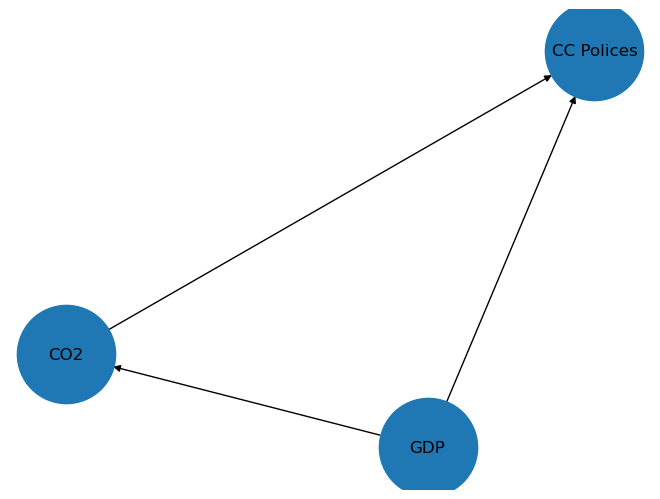

In [334]:
# Create a directed graph
G = nx.DiGraph()

# Adding the nodes to our graph
G.add_edge('GDP', 'CO2')
G.add_edge('GDP', 'CC Polices')
G.add_edge('CO2', 'CC Polices')

nx.draw(G, with_labels=True, node_size=5000)


#### 3.4.2 GDP (per capita) vs CO2 (per capita)


In [65]:
df = df_acc_final.dropna(subset=['gdp_per_capita']).copy()

fig = px.scatter(df, x="gdp_per_capita", y="tot_co2_per_capita_up_till_2010",
                 hover_name="country", trendline='ols', trendline_options=dict(log_x=False),
                 trendline_color_override='red',
                 labels={'gdp_per_capita': 'GDP / Capita (2010) ',
                         'tot_co2_per_capita_up_till_2010': 'CO2 / Capita '},
                 log_x=False)

fig.update_layout(
    title="GDP in 2010 vs Historic per capita CO2 emissions<br>With OLS trendline",
    xaxis_title="GDP per capita ($)",
    yaxis_title="CO2 per capita (tons)",
    font=font_dict
)

results = px.get_trendline_results(fig)
fig.show()
print(f"The correlation is quite high: {df['gdp_per_capita'].corr(df['tot_co2_per_capita_up_till_2010']).round(2)}")

The correlation is quite high: 0.82


In [66]:
df = df_acc_final.dropna(subset=['gdp_per_capita']).copy()

fig = px.scatter(df, x="gdp_per_capita", y="laws_impl_2012_2020",
                 hover_name="country", trendline='ols', trendline_options=dict(log_x=False),
                 trendline_color_override='red',
                 labels={'gdp_per_capita': 'GDP / Capita (2010) ',
                         'cc_laws_year': 'CC laws implemented'},
                 log_x=False)

fig.update_layout(
    title="GDP (per capita) 2010 vs Climate Change laws (2012-2020)<br>With OLS trendline",
    xaxis_title="GDP per capita ($)",
    yaxis_title="# CC laws implemented (2012-2020)",
    font=font_dict
)

results = px.get_trendline_results(fig)
fig.show()
print(f"The correlation is quite low, but positive: {df['gdp_per_capita'].corr(df['laws_impl_2012_2020']).round(2)}")


The correlation is quite low, but positive: 0.1


In [67]:
df = df_acc_final.dropna(subset=['gdp_per_capita', 'tot_co2_per_capita_up_till_2010']).copy()

fig = px.scatter(df, x="tot_co2_per_capita_up_till_2010", y="laws_impl_2012_2020", size='gdp_per_capita',
                 hover_name="country", trendline='ols', trendline_options=dict(log_x=False),
                 trendline_color_override='red',
                 labels={'tot_co2_per_capita_up_till_2010': 'CO2 / Capita (->2010) ', 
                         'laws_impl_2012_2020': 'Climate Change Laws (2012-2020) '},
                 log_x=False)

fig.update_layout(
    title="CO2 emissions vs Climate Change Polices (2012->2020)<br>Circle size depending on GDP/capita. With OLS trendline",
    xaxis_title="CO2 per capita (tons)",
    yaxis_title="Climate Change Policies",
    font=font_dict
)

results = px.get_trendline_results(fig)
fig.show()

#### 3.4.2 Removing GDP bias

If we remove the effects of GDP from the plot between CO2 and climate change laws, would the graph then change?... 

Let's do a statistical test to check it out. And we know that GDP per capita influences CO2 per capita with statistical significance (T-Value of ~16.9). Additionally  GDP per capita seem to influence positively the number of climate change laws and policies implemented between 2012 and 2020. Our hypothesis is that if we regress our variable climate change laws implemented between 2012 and 2020 (`laws_impl_2012_2020`) over CO2 per capita (`tot_co2_per_capita_up_till_2010`) and GDP per capita (`gdp_per_capita`), hence remove the negative omitted variable bias from GDP per capita the effect of will be much smaller.

In [22]:
def short_summary(est): 
	return HTML(est.summary().tables[1].as_html()) 

df = df_acc_final.dropna(subset=['gdp_per_capita', 'tot_co2_per_capita_up_till_2010', 'laws_impl_2012_2020']).copy()

est = smf.ols(formula='laws_impl_2012_2020 ~ tot_co2_per_capita_up_till_2010 + gdp_per_capita', data=df).fit()
short_summary(est)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.1625,0.663,9.296,0.000,4.852,7.473
tot_co2_per_capita_up_till_2010,-0.0011,0.002,-0.665,0.507,-0.004,0.002
gdp_per_capita,5.674e-05,4.56e-05,1.244,0.215,-3.34e-05,0.000


#### 3.4.3 Conclusion for cross-sectional data

What see  in the graphs above and regression tables is that GDP is tightly coupled and a significant predictor for CO2 emissions.

As we predicted the coefficient effect of CO2 per capita did reduce when accounting for GDP per capita. Our statistical summary above shows that the coefficient associated to `tot_co2_per_capita_up_till_2010` went from 0.0008 new laws and policies implemented between 2012 and 2020 per additional CO2 ton emitted per capita until 2010 to -0.0011. 

We also note that the table above states no significance.

So, to summarize: GDP is just ONE example of omitted variables, there are many more, such as:
1.  Government: Countries with stricter environmental regulations may have lower levels of CO2 emissions and stricter climate change laws.
2.  Geography & Climate: Countries with very warmer climates higher levels of CO2 emissions and less strict climate change laws, and at the same time countries with very cold climates may also have higher  levels of CO2 emissions and less stricter climate change laws. Due to either e.g. domestic cooling or warming systems.
3. Energy-mix: Countries with a higher mix of fossil fuels may have higher levels of CO2 emissions and less strict climate change laws, while countries with a higher mix of renewable energy sources may have lower levels of CO2 emissions and stricter climate change laws. 

So, let's try to do some within-country analysis to escape this intricate web of biases.

### 4. Panel data - within-country analysis

#### 4.1 Multivariate clustered analysis

First, we can try to use clustered standard errors,  a method of adjusting the standard errors of the estimates in a linear regression model to account for the fact that the observations within each group  are correlated.

The idea behind clustered standard errors is that the errors within each cluster are more likely to be correlated than the errors between different clusters. By doing this we can improve our predictions, since the method takes into account similarity within-country.

In addition can we add GDP as a predictor, making it a multivariate analysis.

However, using clustered standard errors can also lead to larger standard errors, as the adjustment for the within-cluster correlations increases the variability of the estimates.

We will now move back to the historic panel data, where each country has several observations.

In [23]:
# load historic data and remove NaNs
df = df_historic.dropna(subset=['co2_per_capita', 'cc_laws_year', 'gdp_per_capita']).copy()

# setting more explicit variable names to the regression result
features = ['CO2 per capita', 'GDP per capita']

X = np.array(df[['co2_per_capita', 'gdp_per_capita']])  # predictor variables
y = np.array(df['cc_laws_year'])  # dependent variable

# estimate the parameters of the model using clustering
model = sm.OLS(y, X)
results = model.fit(cov_type='cluster', cov_kwds={'groups': df['country']})

print(results.summary(xname=features))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.147
Model:                            OLS   Adj. R-squared (uncentered):              0.147
Method:                 Least Squares   F-statistic:                              18.27
Date:                Fri, 23 Dec 2022   Prob (F-statistic):                    8.47e-08
Time:                        13:29:21   Log-Likelihood:                         -4035.3
No. Observations:                2875   AIC:                                      8075.
Df Residuals:                    2873   BIC:                                      8086.
Df Model:                           2                                                  
Covariance Type:              cluster                                                  
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

Short summary and interpretation of the clustered regression table above.

* The model explains about 14.7% of the variance in Climate Change Laws.
* The F-statistic is 18.27, proves a good overall significance.
* The independent variable (CO2 per capita) has a coefficient estimate of  -0.0175, which means that for each ton increase in CO2/capita, Climate Change laws is expected to decrease by 0.0175 units. Which is a stronger decrease than what we saw with the non-clustered aggregated data (!)
* The p-value of the coefficient estimate is 0.033, which indicates that the coefficient is statistically significant at 95%. 

So, can we with significance say that polluting more per capita translates to incorporating fewer climate change laws? We are not confident enough in this analysis so we will try to approach our research question from another angle. 

#### 4.2 What if?...

What if we where to look at how much a country emits can effect climate laws implemented two years later? The laws two years later will certainly not effect historic emissions, thus removing reverse causality. We can also argue that emissions data are complicated to calculate, and thereafter we have to expect a political implementation lag. We can use two tables to explain what we will do:


| Year | Country | ISO3 | CO2 per capita | Climate Change Laws Implemented |
| --- | ----------- | ----------- | ----------- | ----------- |
| 2000 | Norway | NOR | 5.0 | 1 |
| 2001 | Norway | NOR | 5.1 | 0 |
| 2002 | Norway | NOR | 4.9 | 1 |
| 2003 | Norway | NOR | 5.2 | 2 |
| 2004 | Norway | NOR | 5.5 | 0 |

So if we shift the CO2 per capita column up by two we will get the following data structure:

| Year | Country | ISO3 | CO2 per capita (t-2)| Climate Change Laws Implemented |
| --- | ----------- | ----------- | ----------- | ----------- |
| 2000 | Norway | NOR | 4.9 | 1 |
| 2001 | Norway | NOR | 5.2 | 0 |
| 2002 | Norway | NOR | 5.5 | 1 |
| 2003 | Norway | NOR | - | 2 |
| 2004 | Norway | NOR | - | 0 |

We have now found a new method to predict the relationship between emissions and climate change laws. This way we can internalize a lot of country differences, so let's try to do this on the large dataset.

#### 4.2.1 Yearly emissions vs Climate Change laws - 2 year shifted

In [68]:
df_historic_shifted = df_historic.copy()
df_historic_shifted = df_historic_shifted.dropna(subset=['cc_laws_year'])
num_years_to_shift = 2

# shifting the co2_per_capita column by -2
df_historic_shifted['co2_per_capita'] = df_historic_shifted.co2_per_capita.shift(-num_years_to_shift)
df_historic_shifted = df_historic_shifted[:-num_years_to_shift]

df_col_row = df_historic_shifted.copy()

fig = px.scatter(df_col_row, x="co2_per_capita", y="cc_laws_year", trendline='ols', trendline_color_override='red', trendline_options=dict(log_x=False),
                 hover_name="country",
                 log_x=False,
                 labels={'cc_laws_year': '#CC laws',
                         'co2_per_capita': 'CO2 year / Capita'},
                 )
fig.update_layout(
    title=f"Yearly Emissions vs {num_years_to_shift} Years Later climate change policies <br> Global",
    xaxis_title="CO2 per capita (tons)",
    yaxis_title="# CC Laws per year",
    font=font_dict
)
results = px.get_trendline_results(fig)
fig.show()
print(results.px_fit_results.iloc[0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.902
Date:                Fri, 23 Dec 2022   Prob (F-statistic):              0.168
Time:                        14:05:53   Log-Likelihood:                -4888.2
No. Observations:                3642   AIC:                             9780.
Df Residuals:                    3640   BIC:                             9793.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5549      0.020     28.030      0.0

#### 4.2.2 Regression analysis 

We can see that there is a small negative correlation between CO2 per capita and climate change laws implemented two years after. As stated, the reasoning behind two years "lag" is that first of all, emissions data are complicated to calculate, and thereafter we have to expect political lag. So it may be that 2 years is even a little optimistic. We can see how changing the `num_years_to_shift` changes the graph. After investigating the difference when choosing  `1,2,3,4,5,6` the coefficient did also change. The variances could be explained by the political lag, or that elections happen every 2nd or 4th years. Since these variances are quite small, and we are not able to conclude with any confidence we will continue with the 2 year lag.

|Lag (year)|Coefficient|
|---|---|
|1|-0.0038|
|2|-0.0035|
|3|-0.0040|
|4|-0.0031|
|5| -0.0041|
|6|-0.0046|

The T-value clearly states that we don't have any significance. Additionally, this data plot does hides all historic changes. And if we want to address our research question, we need to see this data historically.

#### 4.3 Time varying emission data
To gain further understanding, we could divide our data into three different periods:
1. Pre Kyoto Procotol (< 1997), 
2. Pre Paris Agreement (1997 - 2016)
3. Post Paris Agreement (> 2016)

These are three significant events in regards to fighting climate change, but they do not alone explain possible mitigation. There can still be other variances and events affecting climate polices such as political change, economic crisis, natural disasters and so on. So, it's important to address that this can not be seen as an isolated shock.

To simplify we will start by dividing our data into the three periods and see if any changes happen.

In [69]:
df_col = df_col_row.copy()

conditions = [
    df_col['year'] < 1997,
    ((df_col['year'] >= 1997 ) & (df_col['year'] <= 2016)),
    df_col['year'] > 2016,
]

choices = ['pre_kyo', 'pre_par', 'post_par']

df_col['protocol'] = np.select(conditions, choices)

fig = px.scatter(df_col, x="co2_per_capita", y="cc_laws_year", facet_col='protocol', trendline='ols', trendline_color_override='red',
                category_orders={"protocol": ["pre_kyo", "pre_par", "post_par"]},
                hover_name="country",
                log_x=False,
                labels={'cc_laws_year': '#CC laws',
                        'co2_per_capita': 'CO2 per capita'},
                )
fig.update_layout(
    title=f"Yearly Emissions vs {num_years_to_shift} Years Later climate change policies <br> Global",
    xaxis_title="CO2 per capita",
    yaxis_title="CC Laws per year",
    font=font_dict
)
results = px.get_trendline_results(fig)
fig.show()

This is interesting, it seems that the paris agreement has really put pressure on the countries to take action. We could divide into countries that has an higher and lower than avg GDP, but due to lack of data and GDP being a significant predictor for GDP, we'll focus on high versus low emitting countries. Hence divide into two groups: 
1. Above mean `co2_per_capita`
2. Below mean `co2_per_capita`

The hypothesis we are testing is whether high and low polluting countries take different measures after significant climate change events. 

In [74]:
# building upon the previous data set
df_col_row = df_col

# calculating the mean per capita emission
mean_co2 = df_col_row.co2_per_capita.mean()

# defining conditions for above and below mean
condition_co2 = [
    df_col_row['co2_per_capita'] < mean_co2,
    (df_col_row['co2_per_capita'] >= mean_co2) | (np.isclose(df_col_row['co2_per_capita'], mean_co2))
]

choices_co2 = ['below_mean', 'above_mean']

# creating a new "dummy" column called co2_rel, with either the value below_mean or above_mean
df_col_row['co2_rel'] = np.select(condition_co2, choices_co2)

fig = px.scatter(df_col_row, x="co2_per_capita", y="cc_laws_year", facet_col='protocol', facet_row='co2_rel', trendline='ols', trendline_color_override='red',
                category_orders={"protocol": ["pre_kyo", "pre_par", "post_par"]},
                hover_name="country",
                log_x=False,
                labels={'cc_laws_year': '#CC laws',
                        'co2_per_capita': 'CO2 per Capita'},
                )
fig.update_layout(
    title=f"Yearly Emissions vs {num_years_to_shift} Years Later climate change policies (Global) <br> Countries below mean CO2/Capita)",
    font=font_dict
)
results = px.get_trendline_results(fig)
fig.show()


Let's try to make these graphs a bit bigger.

In [71]:
df = df_col_row[df_col_row.co2_rel == 'below_mean']

fig = px.scatter(df, x="co2_per_capita", y="cc_laws_year", facet_col='protocol', trendline='ols', trendline_color_override='red',
                category_orders={"protocol": ["pre_kyo", "pre_par", "post_par"]},
                hover_name="country",
                log_x=False,
                labels={'cc_laws_year': '#CC laws',
                        'co2_per_capita': 'CO2 year / Capita'},
                )
fig.update_layout(
    title=f"Yearly emissions vs {num_years_to_shift} years later climate change policies (Global) <br> Countries below mean CO2/Capita)",
    font=font_dict
)
results = px.get_trendline_results(fig)
fig.show()


In [72]:
df = df_col_row[df_col_row.co2_rel == 'above_mean']

fig = px.scatter(df, x="co2_per_capita", y="cc_laws_year", facet_col='protocol', trendline='ols', trendline_color_override='red',
                category_orders={"protocol": ["pre_kyo", "pre_par", "post_par"]},
                hover_name="country",
                log_x=False,
                labels={'cc_laws_year': '#CC laws',
                        'co2_per_capita': 'CO2 year / Capita'},
                )
fig.update_layout(
    title=f"Yearly emissions vs {num_years_to_shift} years later climate change policies (Global) <br> Countries above mean CO2/Capita)",
    font=font_dict
)
results = px.get_trendline_results(fig)
fig.show()


#### 4.4 The Paris Agreement effect

This is even more interesting, looking at the graphs the paris agreement seemed to have a huge impact on high-polluting countries in implementing climate change laws. And in regards to low-emitting countries, the change is actually negative. Maybe the low emitting countries understood that they where not the problem? Or where they polluting very little because they already had a lot of laws implemented? Another possible limitation is that the mean value we used is the mean for the whole period, to improve accuracy we could calculate the mean for each period (Pre Kyoto, Pre Paris and Post Paris) to have more evenly distributed data for each period. In addition, there are several countries in this dataset that did not ratify the paris agreement. 

So, coming up - we'll use a regression discontinuity design to further investigate the effect of the paris agreement. And lastly, we'll see the case of two concrete neighboring countries with similar emission profiles, one in and one out of the paris agreement and how signing the paris agreement effected the rate of new climate change policies.

### 5. RDD Analysis (Regression discontinuity design)

We will try to focus on the effect the Paris agreement on the number of laws and policies implemented. Note that there may be other incidents happing during that year as well, so we will not be able to isolate the shock of the Paris Agreement by itself. Nevertheless, it may give an impression of how high emitting countries develop through time.

After conducting a small research and according to an article at [Climate Home News](https://www.climatechangenews.com/2020/08/13/countries-yet-ratify-paris-agreement/), The countries that did not join the Paris agreement in 2016 are Iran, Eritrea, Libya, Angola, Kyrgyzstan, Lebanon, Turkey, Iraq, and South Sudan. In order to see the clear effect of the Paris agreement, we will remove them to do the regression discontinuity (RDD).
- How do low vs high emitting countries react to the Paris agreement?
- Based on our previous analysis showing that high emitting countries implement more laws and policies, we expect some similar results in the RDD analysis.


#### 5.1 RDD overall

In [100]:
df_historic_wip = df_historic_clean.copy()
df_historic_wip = df_historic_wip.dropna(
    subset=['cc_laws_year', 'co2_per_capita'])

no_paris_countries = ('Angola', 'Lebanon', 'Iraq', 'Eritrea', 'Turkey', 'Libya', 'Kyrgyzstan', 'Iraq', 'South Sudan')

no_paris_2016_index = df_historic_wip[df_historic_wip.country.isin(
    no_paris_countries)].index

df_historic_wip.drop(index=no_paris_2016_index, inplace=True)

df = df_historic_wip
df = df[df["year"] > 2008]
mean_co2_per_capita = df.co2_per_capita.mean()

df_year_groupby0 = df.groupby(['year'])['cc_laws_year'].mean(
).reset_index(name='mean_cc_laws_year')
df_year_groupby0['threshold'] = (df_year_groupby0["year"] > 2016)

df_year_groupby0.loc[7, "mean_cc_laws_year"] = None


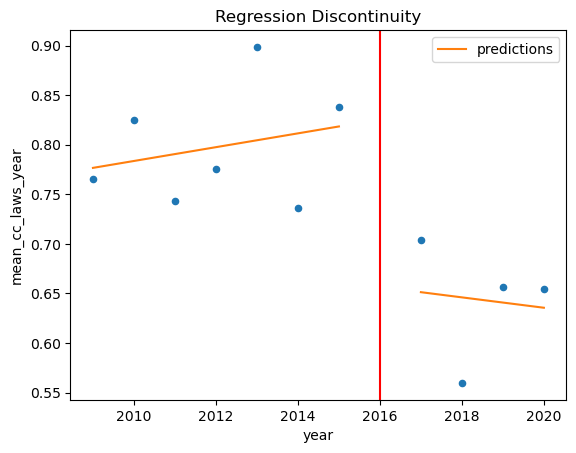

In [101]:
model = smf.wls("mean_cc_laws_year~year+threshold+year*threshold", df_year_groupby0).fit()

ax = df_year_groupby0.plot.scatter(x="year", y="mean_cc_laws_year", color="C0")
df_year_groupby0.assign(predictions=model.fittedvalues).plot(x="year", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity")
plt.axvline(2016, 0,10, color="red")
plt.show()


We see that on average, after the Paris agreement, there are less laws and policies that are implemented every year. 
We don't know exactly why this is happening, however we can do some hypotheses.
- It could either be because in general, countries have already implemented many laws and policies for climate change. 
- However the more plausible hypthesis is that after the Paris agreement, countries take a few years to discuss and think of what and how they can implement new policies in accordance with this new agreement they signed for; we see a small increase in 2019 and 2020 compared to 2018. To further explore this hypothesis we could test the significancy of the raise in climate laws and policies implementation 2-3 years after the Paris agreement.  

#### 5.2 RDD high-emitters

Now we will focus on the high-emitting years of countries, so on the year of a country that emits more than the mean of co2 per capita per country between 2010 and 2020. To simplify we will say that we focus on the high-emitting countries. We are aware that a country can be part of the high and low co2 per capita categories. 

In [102]:
#for more than mean co2_per_capita
df_h= df[(df["co2_per_capita"]>mean_co2_per_capita)]
df_year_groupby_high = df_h.groupby(['year'])['cc_laws_year'].mean().reset_index(name='mean_cc_laws_year')
df_year_groupby_high['threshold'] = (df_year_groupby_high["year"] > 2016)

df_year_groupby_high.loc[7,"mean_cc_laws_year"]=None

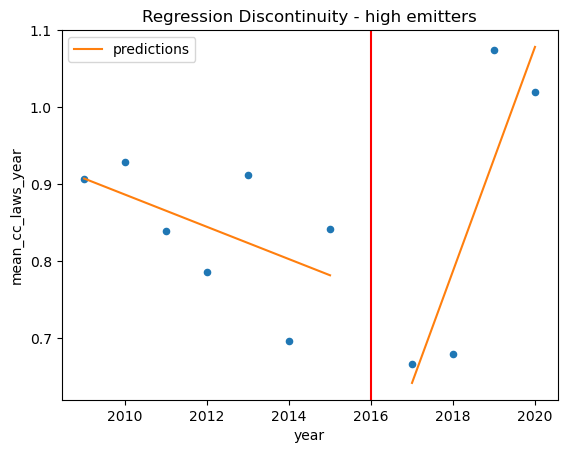

In [103]:
model = smf.wls("mean_cc_laws_year~year+threshold+year*threshold", df_year_groupby_high).fit()

ax = df_year_groupby_high.plot.scatter(x="year", y="mean_cc_laws_year", color="C0")
df_year_groupby_high.assign(predictions=model.fittedvalues).plot(x="year", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity - high emitters")
plt.axvline(2016, 0,10, color="red")

This gives us an idea of how high-emitting countries react to the Paris agreement. 
- Before the Paris agreement, the average number of new laws and policies were decreasing.
- After the Paris agreement, it seems like there is a reaction time of approximately 2-3 years to start implementing new laws and policies, but high-emitting countries seem to react positively. 

#### 5.3 RDD low-emitters

Now we will focus on the low-emitting countries.

In [104]:
#for counties and year with less than the mean co2_per_capita 

df_l= df[(df["co2_per_capita"] < mean_co2_per_capita)]
df_year_groupby_low = df_l.groupby(['year'])['cc_laws_year'].mean().reset_index(name='mean_cc_laws_year')
df_year_groupby_low['threshold'] = (df_year_groupby_low["year"] > 2016)

df_year_groupby_low.loc[7,"mean_cc_laws_year"]=None

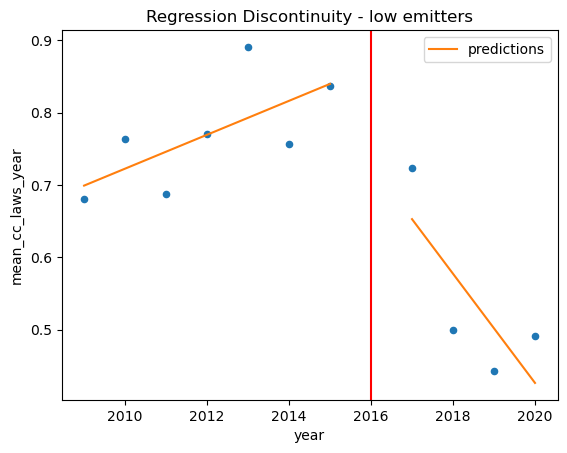

In [105]:
model = smf.wls("mean_cc_laws_year~year+threshold+year*threshold", df_year_groupby_low).fit()

ax = df_year_groupby_low.plot.scatter(x="year", y="mean_cc_laws_year", color="C0")
df_year_groupby_low.assign(predictions=model.fittedvalues).plot(x="year", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity - low emitters")
plt.axvline(2016, 0,10, color="red")

This gives us an idea of how low-emitting countries react to the Paris agreement. After the Paris agreement, it doesn't seem that these countries implement more laws and policies, in fact there seems to be a negative effect of the Paris agreement.
- Maybe the Paris agreement led to the low-emitting countries realizing that they were not the problem? So that they would reduce the number of new laws and policies? 
- Or, did they already have a lot of climate change policies in plays already? This goes back to a point we have made before as well.


#### 5.4 RDD Regression analysis

In [106]:
results1 = smf.ols("mean_cc_laws_year~year+threshold", data=df_year_groupby0).fit()
results2 = smf.ols("mean_cc_laws_year~year+threshold", data=df_year_groupby_high).fit()
results3 = smf.ols("mean_cc_laws_year~year+threshold", data=df_year_groupby_low).fit()
results4 = smf.ols("mean_cc_laws_year~year+threshold+year*threshold", data=df_year_groupby0).fit()
results5 = smf.ols("mean_cc_laws_year~year+threshold+year*threshold", data=df_year_groupby_high).fit()
results6 = smf.ols("mean_cc_laws_year~year+threshold+year*threshold", data=df_year_groupby_low).fit()
stargazer_tab = Stargazer([results1, results2,  results3, results4, results5,  results6])

stargazer_tab

#### 5.5 RDD conclusions

This table summarizes our findings.

The first three regressions are used to see if there is a significant drop in average number of laws and policies implemented every year before and after the Paris agreement. 
- (1) There is a significant drop of 0.187 laws and policies implemented every year between pre-Paris and post-Paris agreement with 95% confidence if we take all high and low emitting countries into account 
- (2) There is no significant change of laws and policies implemented every year between pre-Paris and post-Paris agreement if we only take high emitting countries into account
- (3) There is a significant drop of 0.285 laws and policies implemented every year between pre-Paris and post-Paris agreement with 90% confidence if we only take low emitting countries into account 

The next three regressions help us understand the change in direction between before and after the Paris agreement for low and high emitting countries. 

- (4) If we take into account high and low emitting countries, there is no significant change in slope. 
- (5) There is a significant change of slope for the high emitting countries of approximately + 0,167 new laws and policies (with 99% confidence) 
- (6) There is a significant change of slope for the low emitting countries of approximately - 0.099 new laws and policies (with 95% confidence) 


Overall, our findings are coherent with what we supposed, the Paris agreement refocused the attention on high-emitting countries. However, we did not expect that low-emitting countries would reduce the number of new laws and policies they implement every year. It is coherent with the objectives of Paris agreement, each country must reduce its emissions proportionally with its current emissions. So a low-emitting country would have less work to do than a high-emitting country. As low-emission countries often are poorer (in terms of GDP) and less developed, they still need to implement laws and policies so that as they develop, to limit their emissions.  

We are aware that there are many biases in our analysis. There could be many other events that influence the number of laws and policies implemented each year after 2016 in low vs high emitting countries. Such as:
- The rise in general awareness the last years due to concerning reports about climate change
- Additionaly, famous personalities like Greta Thunberg or Leonardo Dicaprio, may accelerate this interest

There are many factors that correlate with 2016, and it would be difficult to assess the causal effect of the Paris agreement on the number of new climate change laws and policies implemented.

So by concluding our RDD, we introduce another method to highlight the effect of the Paris agreement.

### 6 Comparison between Bulgaria and Turkey 

In order to further investigate the effect of the Paris agreement, we want to compare two similar countries, one that has signed the Paris agreement and one that hasn't. 
These countries are similar in the following way : 
- They have approximately the same emissions per capita in 2016 (6.277 for Bulgaria vs 5.003 for Turkey in tons per capita and per year)
- They have approximately the same gdp per capita in 2016 (17'097 for Bulgaria vs 18'495 for Turkey in $ per year per person)
- They are neighbors, their culture is different but there are some similarities
The Paris Agreement will enter into force for Turkey on Nov. 10, 2021 whereas Bulgaria's date of ratification is the 29 November 2016.

The idea of comparing two "similar" countries is that it allows us to do the hypothesis that they would react in a similar way if they both signed the Paris agreement or if they both didn't.
We are aware of the self-selection bias that the countries have when choosing to sign the Paris agreement: if you are a country that wants to help solve the problem of climate change, you may have a higher probability in signing the treaty and in implementing more laws and policies. 

In order to correct this bias, the countries that sign the Paris agreement should be random. 

The equation is 𝑌𝑠𝑡 = 𝛼 + 𝛾𝑇𝑠 + 𝜆𝑃𝑡 + 𝛽(𝑇𝑠 ∗ 𝑃𝑡) + 𝜖𝑠t
- 𝛼 is the average number of laws and policies of the controll group(Turkey) before the treatment.
- 𝛾 is the average difference of laws and policies between the treated (Bulgaria)group and the not treated group (Turkey).
- 𝜆 is the average difference in the control group (Turkey) between before vs after the treatment.
- 𝛽 is the average change of laws and policies between pre and post intervention in the treated group (Bulgaria) compared to the same average change in the control group (Turkey). 

In [91]:
df_turkey_bulgaria = df_historic[(df_historic.country == 'Turkey') | (df_historic.country == 'Bulgaria')] 
df_turkey_bulgaria = df_turkey_bulgaria[df_turkey_bulgaria.year >= 2010]
df_turkey_bulgaria = df_turkey_bulgaria.dropna(subset=['cc_laws_year'])

condition_treatment = [
    df_turkey_bulgaria['year'] <= 2016,
    df_turkey_bulgaria['year'] > 2016,
]

choices = ['pre_paris', 'post_paris']

df_turkey_bulgaria['treatment'] = np.select(condition_treatment, choices)

df = df_turkey_bulgaria
fig = px.scatter(df, x="year", y="cc_laws_year",
                hover_name="country",
                trendline='ols',
                facet_col='treatment',
                color='country',
                log_x=False,
                labels={'year': 'Year',
                        'cc_laws_year': 'CLimate Change Laws or Polices'},
                )
fig.update_layout(
    title=f"Bulgaria and Turkey Diff in Diff : CC Laws or Policies",
    
    xaxis_title="Year",
    yaxis_title="CC Laws or Policies",
    font=font_dict
)
results = px.get_trendline_results(fig)
fig.add_vline(x=2016)
fig.show()


We can see on this graph that before the Paris agreement, the two countries behave in a similar way: they have the same slope of the number of laws and policies implemented every year. However, after the Paris agreement, Bulgaria's slope increases more than Turkey's one. 

Considered the fact that before the Paris agreement, Bulgaria was implementing less laws and policies on average than Turkey. We will further investigate if there is a significant change between the two countries' numbers of new laws and policies implemented after the Paris agreement using the diff-in-diff method.

In [96]:
df = df_turkey_bulgaria
df['treated'] = df['country'].where(df['country'] == 'Turkey', 0).fillna(1)
df = pd.get_dummies(df, columns=['treated'])
df['post_paris'] = df['country'].where(df['year'] <= 2016, 0).fillna(1)
df = pd.get_dummies(df, columns=['post_paris'])
df['pre_paris'] = df['country'].where(df['year'] > 2016, 0).fillna(1)
df = pd.get_dummies(df, columns=['pre_paris'])
df.drop(columns=[ "treatment","treated_Turkey","treated_Turkey", "post_paris_Bulgaria", "post_paris_Turkey", "pre_paris_Bulgaria", "pre_paris_Turkey"], inplace=True)
df.rename(columns={'post_paris_0': 'post', 'pre_paris_0': 'pre',"treated_0" : "treatment"}, inplace=True)

In [97]:
# fit the model
model = smf.ols(formula='cc_laws_year ~ treatment + pre + post + treatment:post', data=df)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           cc_laws_year   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                    0.6627
Date:                Fri, 23 Dec 2022   Prob (F-statistic):              0.586
Time:                        14:47:24   Log-Likelihood:                -26.467
No. Observations:                  22   AIC:                             60.93
Df Residuals:                      18   BIC:                             65.30
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5476      0.186      2.

The "treatment" coefficient gives us the average difference between Bulgaria (the treated one) and Turkey (the non treated one); it is approx. -0.4286, the difference isn't statistically different though: |t-value| = 0.9.

The "post" coefficient gives the mean difference before and after the treatment, the coefficient is -0.6429 and is not significant (t-value=-1.151). It seems like overall, after 2016, countries have reduced the number of new laws and policies implemented every year. 

In order to see if there is a significant effect of the treatment, meaning the Paris agreement, we will look at the integration between "treatment" and "post" meaning being part of the treatment group (Bulgaria) and after the treatment (>2016). 

- The value of the interaction coefficient is 0.4286 with a t-value of 0.543, meaning that this coefficient isn't significant at a 95% confidence nor at a 90% confidence since its p-value is 0.594 and is higher than 0.1. 

We can't conclude with a causal effect of the Paris agreement on new climate change laws. The threat of self-selection bias certainly plays a role in the difference of slope before and after the Paris agreement for Bulgaria. In addition, we do not have enough data to see how the countries' behavior evolves after the Paris agreement. 

### 7. Conclusion

We have conducted several statistical regressions to assess the causal effect of emissions on climate change laws. Interestingly as we saw in the aggregated data, we where only able to display the negative coefficient of CO2 emissions on new climate change laws when we addressed the omitted variable bias of GDP. But when we divided our data into separate periods in time, we where able to distinguish behavior. According to our findings, high-emitting countries have incorporated more climate change laws and polices, with a significant shift around 2016. But, is it because they did not already have any climate change laws we saw the increase? Or is it because they genuinely care about the environment. This could, with more time be addressed by further categorize countries into groups above or below mean accumulated number of climate change laws in place. Finally, it would be very interesting to see how countries experiencing a lot of threats from climate change, such as frequent extreme weather events react differently from countries with isolated from climate change.